# Gold Price Forecasting using Linear Models

## Introduction

This notebook aims to forecast gold prices using various linear modeling techniques. Accurate prediction of gold prices is crucial for investors, traders, and financial analysts, as gold is a key commodity in global markets and often considered a safe-haven asset during economic uncertainty.

In this notebook, we implement several linear models such as Linear Regression, Ridge Regression, Lasso Regression, and Elastic Net, to predict future gold prices based on historical data. These models are well-known for their simplicity and interpretability, which makes them a good starting point for financial forecasting tasks.

## Importing Libraries and Packages

In [1]:
# Disable warning messages for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np

# Libraries for data visualization (matplotlib, seaborn, plotly)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For time series stationarity testing
from statsmodels.tsa.stattools import adfuller

# Machine learning models (Linear, Ridge, Lasso, ElasticNet)
# and utility functions (train/test split, performance metrics)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Statistical functions for hypothesis testing
from scipy.stats import t

## Data Loading

The dataset used in this notebook consists of historical gold prices from the GLD ETF, along with several engineered features created in the `dataprep.py` script. Key features include:

+ **Momentum Indicators** : Various moving averages (e.g., MA3, MA9) and exponential moving averages (e.g., EMA_8).
+ **Volatility Measures** : Rolling standard deviations (e.g., STD_5).
+ **Return Metrics** : Cumulative percentage changes over short periods (e.g., PCT_3).
+ **Additional Indicators** : Related financial instruments such as GDX (Gold Miners ETF), USO (Oil Fund ETF), 10-Year Treasury Yield, and the US Dollar Index (DXY).

This prepared data will be used to build and evaluate predictive models.

In [2]:
# Load gold price dataset, setting 'Date' as the index and parsing dates
data = pd.read_csv('gold_data.csv', index_col='Date', parse_dates=True)

# Select all columns starting from the 6th column as features for the model
feature_list = data.columns.tolist()[5:]

In [3]:
# Display a random sample of 10 rows from the dataset to inspect the data
data.sample(10)

,Open,High,Low,Close,Volume,MA3,MA9,MA10,MA15,MA20,...,PCT_3,PCT_6,PCT_9,VM_4,CO,HL,GDX_Close,USO_Close,10Y_Treasury_Yield,DXY_Close
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-19,120.809998,121.029999,120.580002,120.800003,4925800,121.083333,122.415556,122.466000,122.589334,122.689000,...,-0.020989,-0.019762,-0.017240,7831050.0,-0.009995,0.449997,20.601360,105.120003,2.893,95.089996
2014-05-27,122.980003,123.070000,121.750000,121.849998,10895800,123.676666,124.418889,124.437000,124.515333,124.594500,...,-0.020396,-0.021277,-0.021996,5851750.0,-1.130005,1.320000,20.400042,305.119995,2.518,80.349998
2014-05-16,124.349998,124.769997,124.290001,124.500000,4052100,125.026665,124.782221,124.925999,124.805333,124.692500,...,-0.000719,0.002764,-0.013504,4143150.0,0.150002,0.479996,21.319456,297.839996,2.518,80.040001
2018-04-06,126.570000,126.599998,126.129997,126.389999,6121200,126.213333,126.610001,126.710001,126.222667,126.040001,...,0.000737,0.005357,-0.009356,6256550.0,-0.180000,0.470001,20.620045,100.080002,2.775,90.110001
2023-02-21,171.199997,171.500000,170.339996,170.619995,4035900,170.876663,172.156665,172.338998,173.976666,175.424500,...,-0.001569,-0.015857,-0.019390,4702475.0,-0.580002,1.160004,27.655882,66.690002,3.955,104.180000
2013-10-16,123.519997,123.889999,122.510002,123.540001,8523400,123.366669,124.961111,125.183000,125.894666,126.606499,...,0.007668,-0.030487,-0.028705,9749600.0,0.020004,1.379997,20.994854,295.359985,2.671,80.500000
2010-10-29,131.479996,132.820007,131.059998,132.619995,14334900,131.126668,130.637780,131.002002,131.784668,131.503001,...,0.013404,0.024274,-0.011568,14266875.0,1.139999,1.760010,50.658886,281.359985,2.612,77.269997
2013-05-02,142.000000,142.470001,141.639999,141.919998,11502200,141.933334,140.421112,139.926001,138.299334,141.730000,...,-0.002584,0.025757,0.047183,11930550.0,-0.080002,0.830002,26.721540,267.920013,1.631,82.209999
2011-06-13,148.660004,149.039993,147.190002,147.770004,12989300,149.190002,149.767778,149.755000,149.364667,148.466000,...,-0.013611,-0.016334,-0.012449,10647475.0,-0.889999,1.849991,46.746147,306.079987,2.991,74.510002


In [4]:
# Create an interactive plot of the Gold ETF price using Plotly
fig = go.Figure()

# Add a trace to plot the 'Close' price as a line graph
fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['Close'], 
    mode='lines', 
    name='Gold ETF', 
    line=dict(color='gold', width=2),
    hoverinfo='x+y'  # Show date and price on hover
))

# Customize plot layout with titles, gridlines, and a range slider for zooming
fig.update_layout(
    title='Gold ETF Price Series',
    xaxis_title='Date',
    yaxis_title='Gold ETF Prices (USD)',
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True, 
        gridcolor='lightgrey',
        tickformat='%Y-%m',  # Display dates as year and month
        rangeslider=dict(visible=True)  # Enable a range slider
    ),
    yaxis=dict(
        showgrid=True, 
        gridcolor='lightgrey'
    ),
    font=dict(size=12),
    hovermode='x unified'  # Show hover information across all traces at once
)

# Display the interactive plot
fig.show()

In [5]:
# Print the number of explanatory variables (features) being used
print(f'Number of Explanatory Variables (Features): {len(feature_list)}')

Number of Explanatory Variables (Features): 22


## Stationarity Testing

Time series forecasting models often assume that the underlying data is stationary, meaning its statistical properties, such as mean and variance, do not change over time. To verify this assumption, we use the Augmented Dickey-Fuller (ADF) test to check whether each feature in our dataset is stationary.

In [6]:
# Function to check if a time series is stationary using the Augmented Dickey-Fuller test
def isStationary(series):
    pvalue = adfuller(series)
    return pvalue[1] < 0.05  # Return True if p-value < 0.05 (stationary)

# Test each feature in the feature list for stationarity
print('Testing Feature Explanatory Variables for Stationarity:')
for i in range(len(feature_list)):
    stationary = isStationary(data[feature_list[i]])
    print(f'{feature_list[i]} {"Stationary" if stationary else "Non-Stationary"}')

Testing Feature Explanatory Variables for Stationarity:
MA3 Non-Stationary
MA9 Non-Stationary
MA10 Non-Stationary
MA15 Non-Stationary
MA20 Non-Stationary
MA25 Non-Stationary
EMA_8 Non-Stationary
EMA_16 Non-Stationary
EMA_24 Non-Stationary
STD_5 Stationary
STD_10 Stationary
STD_15 Stationary
PCT_3 Stationary
PCT_6 Stationary
PCT_9 Stationary
VM_4 Stationary
CO Stationary
HL Stationary
GDX_Close Non-Stationary
USO_Close Stationary
10Y_Treasury_Yield Non-Stationary
DXY_Close Non-Stationary


## Data Preparation

Before we begin training our models, we need to prepare the data by defining the target variable and splitting the dataset into training and testing sets. We set the target variable as the next day's closing price by shifting the 'Close' column by one day. This allows our models to learn from past prices to predict future prices. We also split the data into training and testing sets, with data prior to 2022 used for training and data after 2022 reserved for testing. Additionally, we perform an 80-20 split within the training data to create a validation set.

In [7]:
# Define the target variable as the next day's closing price by shifting 'Close' column
data['next_day_price'] = data['Close'].shift(-1)

# Remove any rows with missing values resulting from the shift
data = data.dropna()

# Split the data into training features (X) and target variable (y) for dates before 2022
X = data.loc[data.index < '2022-01-01', feature_list]
y = data.loc[data.index < '2022-01-01', 'next_day_price']

# Set aside data after 2022 for testing
test = data[data.index >= '2022-01-01']

Finally, we standardize the features using the StandardScaler, ensuring that each feature has a mean of 0 and a variance of 1. This helps improve the performance and convergence of linear machine learning algorithms.

In [8]:
from sklearn.preprocessing import StandardScaler

# Calculate the 80-20 split point for the training and testing sets
split_point = int(len(X) * 0.8)

# Split the features and target into training (80%) and validation (20%) sets
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

# Standardize the features (mean = 0, variance = 1) using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit to training data and transform
X_test = scaler.transform(X_test)  # Transform testing data using the same scaler

## Model Implementation

### Ordinary Least Squares (OLS) Regression

OLS aims to minimize the sum of the squared differences between the observed and predicted values of the target variable. It assumes a linear relationship between the input features and the target variable and fits a line (or hyperplane) that best explains the variation in the target.

This model serves as a baseline for comparison with more advanced regression techniques. We will train the OLS model on the training data and evaluate its performance on the validation set.

In [9]:
# Create and train a LinearRegression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict target values for both training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the Mean Squared Error (MSE) and R-squared (R2) for both sets
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Display the performance metrics for the training and test sets
print(f'MSE on training set: {mse_train:.4f}')
print(f'R2 on training set: {r2_train:.4f}')
print(f'MSE on test set: {mse_test:.4f}')
print(f'R2 on test set: {r2_test:.4f}')

MSE on training set: 1.9977
R2 on training set: 0.9960
MSE on test set: 2.9242
R2 on test set: 0.9907


In [10]:
# Create a DataFrame to store and compare the performance metrics of the model
df_results = pd.DataFrame({
    'OLS': [mse_train, r2_train, mse_test, r2_test]},  # Store MSE and R2 for train/test sets
    index=['MSE - Train', 'R2 - Train', 'MSE - Test', 'R2 - Test']
)

### Forward Variable Selection

The goal of forward selection is to iteratively build a model by starting with no features and adding them one by one. At each step, the feature that improves the model performance the most (according to a chosen criterion) is added to the model.

This approach helps in identifying the most important features that contribute to predicting the target variable, while avoiding overfitting by reducing the dimensionality of the model.

In [11]:
def best_feature_selection(X, y):
    """
    Selects the feature with the smallest p-value based on hypothesis tests for regression coefficients.

    Parameters:
    - X: array-like, shape (n_samples, n_features), features
    - y: array-like, shape (n_samples,), target variable

    Returns:
    - best_feature: int, index of the feature with the smallest p-value
    - pvalues: array-like, shape (n_features,), p-values of the tests for all features
    """
    n = X.shape[0]  # Number of samples
    best_feature = None
    best_pvalue = float('inf')
    pvalues = []

    for k in range(X.shape[1]):
        # Fit a linear regression model using only the k-th feature
        model = LinearRegression()
        model.fit(X[:, k].reshape(-1, 1), y)

        # Calculate the t-statistic for the coefficient of the k-th feature
        theta_k = model.coef_[0]
        y_pred = model.predict(X[:, k].reshape(-1, 1))
        residuals = y - y_pred
        s_squared = np.sum(residuals ** 2) / (n - 1)
        std_err = np.sqrt(s_squared / np.sum(X[:, k] ** 2))
        t_stat = theta_k / std_err

        # Calculate the two-tailed p-value
        p_value = 2 * (1 - t.cdf(np.abs(t_stat), n - 1))

        # Update the best feature and corresponding p-value if applicable
        if p_value < best_pvalue:
            best_feature = k
            best_pvalue = p_value

        # Store the p-value for the k-th feature
        pvalues.append(p_value)

    return best_feature, pvalues

In [12]:
def forward_variable_selection(X, y):
    """
    Performs iterative forward variable selection with early stopping.

    Parameters:
    - X: array-like, shape (n_samples, n_features), features
    - y: array-like, shape (n_samples,), target variable

    Returns:
    - S: set, indices of the selected features
    - all_p_values: list, p-values of the tests for all features for each iteration
    """

    # Initialize the set of selected features (S) and copy of the original features (X)
    S = []
    X_remaining = X.copy()
    remaining_features = list(range(X.shape[1]))  # Track original indices of features

    all_p_values = []

    while X_remaining.shape[1] > 0:
        # Select the best feature based on the smallest p-value
        best_feature, p_values = best_feature_selection(X_remaining, y)

        # Stop if the best feature's p-value exceeds the threshold
        if p_values[best_feature] > .05:
            break

        # Map the selected feature back to its original index
        selected_feature = remaining_features[best_feature]
        S.append(selected_feature)

        # Remove the selected feature from the remaining features
        X_remaining = np.delete(X_remaining, best_feature, axis=1)
        remaining_features.pop(best_feature)

        # Update the target variable (y) by removing the contribution of the selected feature
        model = LinearRegression()
        model.fit(X[:, selected_feature].reshape(-1, 1), y)
        y = y - model.predict(X[:, selected_feature].reshape(-1, 1))

        # Store p-values for this iteration
        all_p_values.append(p_values)

    return S, all_p_values

In [13]:
# Perform forward variable selection to identify significant features
selected_features, all_p_values = forward_variable_selection(X_train, y_train)
print(f'Selected features in order of selection: {selected_features}')

# Create an interactive Plotly figure to visualize p-values over iterations
fig = go.Figure()

# Add traces for the first 5 iterations (or fewer if less than 5 iterations exist)
for i in range(min(5, len(all_p_values))):
    fig.add_trace(go.Scatter(
        x=list(range(len(all_p_values[i]))),  # Feature indices
        y=all_p_values[i],  # Corresponding p-values
        mode='lines+markers',
        name=f'Iteration {i+1}'
    ))

# Update layout settings for better visualization
fig.update_layout(
    title='P-values for Coefficients in Forward Variable Selection',
    xaxis_title='Feature Index',
    yaxis_title='P-values',
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1,
        title='Feature Index',
        showgrid=True,  # Enable grid lines for clarity
        gridcolor='lightgray',  # Set grid line color
        gridwidth=0.5  # Set grid line width
    ),
    yaxis=dict(
        title='P-values',
        rangemode='tozero',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        showgrid=True,  # Enable grid lines for clarity
        gridcolor='lightgray',  # Set grid line color
        gridwidth=0.5  # Set grid line width
    ),
    plot_bgcolor='white',
    font=dict(size=12),
    legend=dict(x=0, y=1.1, orientation='h')  # Adjust legend position and orientation
)

# Display the plot
fig.show()

Selected features in order of selection: [0, 12, 16, 13, 17, 11]


With the most predictive features selected through Forward Variable Selection, we now move on to fitting the OLS model using only these selected features. This should result in a more efficient model that focuses on the variables most relevant to forecasting gold prices, potentially improving both accuracy and interpretability.

In [14]:
# Select the features identified during forward variable selection
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Create and fit a Linear Regression model using the selected features
model = LinearRegression()
model.fit(X_train_selected, y_train)

# Generate predictions for both training and test sets
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

# Calculate and display Mean Squared Error (MSE) and R-squared (R²) metrics for evaluation
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Output the evaluation results
print(f'MSE on training set: {mse_train:.4f}')
print(f'R2 on training set: {r2_train:.4f}')
print(f'MSE on test set: {mse_test:.4f}')
print(f'R2 on test set: {r2_test:.4f}')

MSE on training set: 2.1789
R2 on training set: 0.9957
MSE on test set: 3.1190
R2 on test set: 0.9901


In [15]:
# Add the performance metrics from the forward variable selection model to the results dataframe
df_results['Forward Variable Selection'] = [mse_train, r2_train, mse_test, r2_test]

### Regularized Regression Models

To prevent overfitting in linear regression models, we implement regularized regression techniques such as Ridge, Lasso, and Elastic Net. These methods introduce a penalty to the regression coefficients, which helps reduce the model's complexity and improves its ability to generalize to unseen data.

+ **Ridge Regression** : Uses an L2 penalty, which shrinks the coefficients, reducing their magnitude without setting any to zero.
+ **Lasso Regression** : Applies an L1 penalty, which can shrink some coefficients to zero, effectively performing feature selection during the modeling process.
+ **Elastic Net** : Combines both L1 (Lasso) and L2 (Ridge) penalties, providing a balanced approach that can handle both multicollinearity and automatic feature selection.

In [16]:
def regression_with_penalty(penalty_params, model_type):
    """
    Perform regression with penalty for a range of parameters and return performance metrics.

    Parameters:
    - penalty_params: array-like, penalty parameters to be tested
    - model_type: str, type of regression model ('ridge', 'lasso', 'elastic_net')

    Returns:
    - min_train_mse: float, Minimum MSE on training set
    - max_train_r2: float, Maximum R² on training set
    - min_test_mse: float, Minimum MSE on test set
    - max_test_r2: float, Maximum R² on test set
    """
    
    # Use global datasets for training and testing
    global X_train, X_test, y_train, y_test

    # Initialize metrics storage
    test_r2_scores = []
    train_r2_scores = []
    test_mse = []
    train_mse = []

    # Loop through each penalty parameter
    for alpha in penalty_params:
        # Select the model based on the specified type
        if model_type == 'ridge':
            model = Ridge(alpha=alpha)
        elif model_type == 'lasso':
            model = Lasso(alpha=alpha)
        elif model_type == 'elastic_net':
            model = ElasticNet(alpha=alpha)
        else:
            raise ValueError("Invalid model type. Choose 'ridge', 'lasso', or 'elastic_net'.")

        # Standardize features for both training and testing sets
        scaler_X = StandardScaler()
        X_train = scaler_X.fit_transform(X_train)
        X_test = scaler_X.transform(X_test)

        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Record R² scores for training and testing sets
        train_r2_scores.append(model.score(X_train, y_train))
        test_r2_scores.append(model.score(X_test, y_test))

        # Calculate and store MSE for training and testing sets
        train_mse.append(mean_squared_error(y_train, model.predict(X_train)))
        test_mse.append(mean_squared_error(y_test, model.predict(X_test)))

    # Return the best performance metrics
    return min(train_mse), max(train_r2_scores), min(test_mse), max(test_r2_scores)

In [17]:
# Define the range of penalty parameters on a logarithmic scale
penalty_params = np.logspace(-1, 6, num=30)

# Perform ridge regression
df_results['Ridge'] = regression_with_penalty(penalty_params, 'ridge')

In [18]:
# Define the range of penalty parameters on a logarithmic scale
penalty_params = np.logspace(-3, 2, num=30)

# Perform Lasso regression
df_results['LASSO'] = regression_with_penalty(penalty_params, 'lasso')

In [19]:
# Define the range of penalty parameters on a logarithmic scale
penalty_params = np.logspace(-3, 6, num=30)

# Perform Elastic Net regression
df_results['Elastic Net'] = regression_with_penalty(penalty_params, 'elastic_net')

### Principal Component Regression (PCR)

PCR is particularly useful when dealing with multicollinearity among features, which can negatively impact the performance of linear models. PCA transforms the original features into a set of uncorrelated components (principal components) that capture the most variance in the data. The linear regression model is then fitted using these components instead of the original features.

By using PCR, we aim to improve the model's robustness and prediction accuracy by leveraging only the most important components of the data, thereby reducing noise and overfitting.

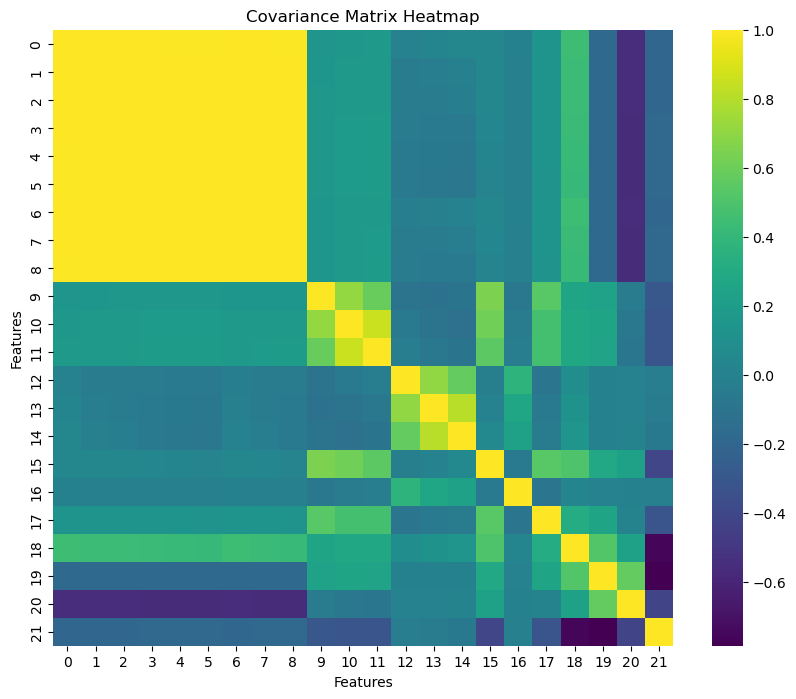

In [20]:
# Compute the covariance matrix of the training features
cov_matrix = X_train.T @ X_train/X_train.shape[0]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, cmap='viridis', annot=False)
plt.title('Covariance Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

The heatmap above visualizes the covariance between features in the dataset. A block of highly correlated features appears in the top-left (bright yellow), indicating significant multicollinearity among these variables, likely momentum indicators or related metrics. The middle of the heatmap shows moderate correlations between some features (possibly different time windows for moving averages or other indicators.), while the bottom-right reveals a mix of more independent features (different types of indicators, such as volatility measures, daily momentum, or external economic factors like treasury yields or dollar index). These patterns suggest that multicollinearity may be present, which could affect model stability.

In [21]:
# Perform Singular Value Decomposition (SVD) on the covariance matrix
U, s, V = np.linalg.svd(cov_matrix)

# Sort singular values and their corresponding eigenvectors in descending order
sorted_indices = np.argsort(s)[::-1]
sorted_singular_values = s[sorted_indices]
principal_components = V.T[sorted_indices]

# Transform the training data using the principal components
X_pca = X_train.dot(principal_components)

In [22]:
# Calculate variance explained by each principal component
explained_variance = (s**2) / (len(X_pca) - 1)
explained_variance_ratio = explained_variance / sum(explained_variance)

# Compute cumulative explained variance for all components
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Identify the optimal number of components to reach 95% variance explained
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Create a Plotly figure for visualizing cumulative explained variance
fig = go.Figure()

# Plot cumulative explained variance ratio against the number of components
fig.add_trace(go.Scatter(
    x=list(range(1, len(explained_variance_ratio) + 1)),
    y=cumulative_explained_variance,
    mode='lines+markers',
    marker=dict(size=8, color='blue'),
    line=dict(color='blue', width=2),
    name='Cumulative Explained Variance Ratio'
))

# Add a horizontal dashed line at the 95% variance threshold
fig.add_trace(go.Scatter(
    x=[1, len(explained_variance_ratio)],
    y=[0.95, 0.95],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='95% Threshold'
))

# Optionally add a vertical dashed line at the optimal number of components
fig.add_trace(go.Scatter(
    x=[optimal_components, optimal_components],
    y=[0, 1],
    mode='lines',
    line=dict(color='green', dash='dash'),
    name=f'{optimal_components} Components'
))

# Update layout of the plot
fig.update_layout(
    title='Amount of Variance Explained by Components',
    xaxis_title='Number of Components',
    yaxis_title='Cumulative Explained Variance Ratio',
    xaxis=dict(tickmode='linear'),
    yaxis=dict(range=[0.75, 1]),  # Set y-axis limits for better visibility
    font=dict(size=12),
    showlegend=True
)

# Display the plot
fig.show()

The plot above shows the cumulative explained variance ratio against the number of principal components, with the goal of determining the number of components required to capture 95% of the variance in the data. The red dashed line represents the 95% variance threshold, while the green dashed line indicates the optimal number of components, which is found to be 3 in this case. This means that the first 3 principal components together account for 95% of the variance in the dataset, making them sufficient for reducing dimensionality while retaining most of the information. We will proceed by using these 3 components in the subsequent modeling steps.

In [23]:
# Project data onto the first two principal components (k=2)
projected_data = X_pca[:, :2]

# Create a Plotly figure for 3D visualization
fig = go.Figure()

# Add a 3D scatter plot of the projected data
fig.add_trace(go.Scatter(
    x=projected_data[:, 0],  # X-axis: first principal component
    y=projected_data[:, 1],  # Y-axis: second principal component
    mode='markers',
    marker=dict(
        size=5,  # Marker size
        color=y,  # Color markers based on gold price (target variable)
        colorscale='Viridis',  # Color scale for visualization
        colorbar=dict(title='Gold Price')  # Add colorbar with title
    ),
    name='Projected Data'
))

# Update layout for improved visuals
fig.update_layout(
    title='Projected Data with Color Based on Price',
    scene=dict(
        xaxis_title='Principal Component 1',  # X-axis label
        yaxis_title='Principal Component 2',  # Y-axis label
    ),
    font=dict(size=12)  # Font size for layout
)

# Display the plot
fig.show()

There appears to be a pattern in the data where higher gold prices (yellow/green points) cluster on one side of the plot, while lower prices (blue/purple points) cluster on the opposite side. This indicates that the first two principal components effectively capture the variance in gold prices.

Moreover, The spread of the data along both axes suggests that the principal components successfully reduce the dimensionality of the dataset while retaining meaningful information regarding the target variable (gold price).

In [24]:
# Initialize variables to track the best model performance
best_score = 0
best_mse = None
best_k = None
scores = []

# Iterate over k values for PCA components
for k in range(1, min(50, X_pca.shape[1])+1):
    # Select the first k principal components for regression
    X_pcr = X_pca[:, :k]

    # Fit the OLS model to the selected components
    model = LinearRegression()
    model.fit(X_pcr, y_train)

    # Predict the target variable using the transformed test data
    y_pred = model.predict(X_test.dot(principal_components[:, :k]))
    
    # Calculate the R-squared score and MSE for the predictions
    score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store the score and update best model parameters if applicable
    scores.append(score)
    if score > best_score:
        best_score = score
        best_mse = mse
        best_k = k

In [25]:
# Print the best k value and corresponding R-squared score
print(f"The best score is achieved with k = {best_k} and the R-squared score is {best_score:.4f}.")

# Create a Plotly figure for visualization
fig = go.Figure()

# Add the R-squared scores plot for each k value
fig.add_trace(go.Scatter(
    x=list(range(1, X_pca.shape[1] + 1)),
    y=scores,
    mode='markers+lines',
    marker=dict(color='blue', size=8),
    line=dict(color='blue', width=2),
    name='R-squared Score'
))

# Add a vertical line indicating the best k value
fig.add_trace(go.Scatter(
    x=[best_k, best_k],
    y=[min(scores), max(scores)],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f'Best k = {best_k}'
))

# Update layout for the plot
fig.update_layout(
    title='Evolution of Scores with Number of Components (k)',
    xaxis_title='Number of Components (k)',
    yaxis_title='R-squared Score',
    xaxis=dict(range=[1, min(50, X_pca.shape[1])+1]),
    yaxis=dict(range=[0.975,  1]),  # Extend y-axis slightly for better visibility
    showlegend=True
)

# Show the plot
fig.show()

The best score is achieved with k = 22 and the R-squared score is 0.9907.


Interestingly, since the initial number of features was also 22, this indicates that reducing the number of components did not lead to any significant performance gains. Instead, retaining all features allowed the model to capture the full complexity of the data. While dimensionality reduction through techniques like PCA can often improve generalization by removing noise or redundant information, in this case, all original features appear to contribute valuable information to the model's predictions.

In [26]:
# Store the best MSE and R-squared score for the PCR model in the results dataframe
df_results['PCR'] = [best_mse, best_score, best_mse, best_score]

## Models Performance Comparison

In [27]:
df_results

,OLS,Forward Variable Selection,Ridge,LASSO,Elastic Net,PCR
MSE - Train,1.997693,2.178920,2.056063,2.111951,2.103041,2.924230
R2 - Train,0.996012,0.995651,0.995896,0.995784,0.995802,0.990679
MSE - Test,2.924230,3.118988,2.949721,3.023913,2.977143,2.924230
R2 - Test,0.990679,0.990058,0.990598,0.990361,0.990510,0.990679


+ OLS and PCR achieve the best performance on the test set, with the lowest MSE (2.924230) and highest R² (0.990679).
+ Ridge, Lasso, and Elastic Net also perform well, with slightly higher test MSE values but comparable R² scores. These regularized models show robust generalization, with Ridge slightly outperforming Lasso and Elastic Net in terms of MSE on the test set.
+ Forward Variable Selection slightly underperforms relative to the other models, with marginally higher MSE and lower R², likely due to the limited set of selected features.

Overall, OLS and PCR perform the best on this dataset, while the regularized models offer similar, reliable performance, indicating that regularization was not significantly required for this particular problem.

Now, we can visualize the predictions made by the best-performing models (OLS and PCR) on the test set and compare them to the actual gold prices.

In [28]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Fit and transform training data
test[feature_list] = scaler.transform(test[feature_list])  # Transform test data using the same scaler

# Fit a linear regression model on the standardized features
model = LinearRegression().fit(X, y)

# Predict the target variable for the test dataset
y_test_pred = model.predict(test[feature_list])

In [29]:
# Plot actual vs predicted prices
fig = go.Figure()

# Add actual prices trace
fig.add_trace(go.Scatter(
    x=test.index,  # Use the last indices for the test set
    y=test['next_day_price'],
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue'),
))

# Add predicted prices trace
fig.add_trace(go.Scatter(
    x=test.index,  # Use the last indices for the test set
    y=y_test_pred,
    mode='lines',
    name='Predicted Prices',
    line=dict(color='red', dash='dash')
))

# Customize the layout
fig.update_layout(
    title='Actual vs Predicted Prices',
    xaxis_title='Date',
    yaxis_title='Gold Prices (USD)',
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True, 
        gridcolor='lightgrey',
        tickformat='%Y-%m',  # Format dates to show year and month
        rangeslider=dict(visible=True)  # Add range slider for zooming
    ),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    font=dict(size=12),
    legend=dict(x=0, y=1.1, orientation='h'),
)

# Show the plot
fig.show()

## Trading Strategy Simulation

In this section, we begin implementing a simple trading strategy that leverages the model's forecasted prices. By comparing the model's predicted next-day prices with the actual prices, we generate signals that can guide potential trading actions, such as going long (buy) or holding a position.

The price indicator is calculated based on the difference between the predicted and actual next-day prices. This indicator serves as the core of our trading strategy, providing actionable insights into whether the model anticipates upward or downward price movements.

Once the trading signals are generated, we will later evaluate the performance of this strategy by analyzing some known metrics.

In [30]:
# Create a DataFrame
gold = pd.DataFrame()

# Store actual and predicted prices, along with daily returns
gold['Price'] = test['Close']  # Actual closing price
gold['Predicted_price_next_day'] = y_test_pred  # Model's predicted price for the next day
gold['Actual_price_next_day'] = test['next_day_price']  # Actual price for the next day
gold['Daily Returns'] = gold['Price'].pct_change()  # Calculate daily returns

# Generate a long signal based on price indicators
gold['Price_indicator'] = (test['next_day_price'] - y_test_pred) / test['next_day_price'] * 10

# Display a sample of the data signals
gold.sample(5)

,Price,Predicted_price_next_day,Actual_price_next_day,Daily Returns,Price_indicator
Date,,,,,
2024-04-05,215.139999,213.642411,216.479996,0.017114,0.131078
2022-02-03,168.600006,168.249381,168.860001,-0.001421,0.036161
2022-07-01,168.320007,168.763985,164.750000,-0.000831,-0.243641
2022-04-06,179.660004,179.604402,180.339996,0.002343,0.040789
2024-03-21,201.970001,200.350663,200.350006,-0.001039,-0.000033


In this trading strategy, we define dynamic thresholds to classify the model's price predictions as undervalued or overvalued. These thresholds help generate trading signals based on the forecasted price movements:

+ **Lower Threshold** (-0.3): When the price indicator falls below this level, the asset is considered undervalued, signaling a potential buy opportunity.
+ **Upper Threshold** (0.35): When the price indicator rises above this level, the asset is considered overvalued, signaling a potential sell or hold decision.

These specific threshold values are not arbitrary. They were chosen with the goal of maximizing the Sharpe ratio, which measures risk-adjusted returns, while also minimizing maximum drawdown, a metric that reflects the largest loss from a peak to a trough in the strategy's performance. This optimization helps ensure that the trading strategy not only delivers profitable returns but also manages risk effectively.

In [31]:
# Plot price and indicator
fig = make_subplots()

# Add the Price Indicator line to the plot
fig.add_trace(go.Scatter(x=gold.index, y=gold['Price_indicator'], mode='lines', name='Price Indicator'))

# Define dynamic thresholds for indicators
lower_threshold = -0.3  # Threshold for Undervalued
upper_threshold = 0.35   # Threshold for Overvalued

# Add horizontal lines for Neutral, Undervalued, and Overvalued indicators
fig.add_trace(go.Scatter(x=[gold.index.min(), gold.index.max()], y=[0, 0], 
                         mode='lines', line=dict(color='black', dash='dash'), name='Neutral'))

fig.add_trace(go.Scatter(x=[gold.index.min(), gold.index.max()], y=[lower_threshold, lower_threshold], 
                         mode='lines', line=dict(color='green', dash='dash'), name='Undervalued'))

fig.add_trace(go.Scatter(x=[gold.index.min(), gold.index.max()], y=[upper_threshold, upper_threshold], 
                         mode='lines', line=dict(color='red', dash='dash'), name='Overvalued'))

# Update layout with titles and dimensions
fig.update_layout(
    title='Price Indicator Plot',
    xaxis_title='Date',
    yaxis_title='Price Indicator',
    legend_title='Legend',
    autosize=False,
    width=1100,
    height=500
)

# Display the plot
fig.show()

In [32]:
# Implement a Trading Strategy Based on the Price Indicator

# Initialize trading signal and position columns
gold['Trading Signal'] = 0.0  # No initial signals
gold['Position'] = 0  # 1 for long, -1 for short, 0 for no position
gold['Strategy Returns'] = 0.0  # Initialize returns

# Generate trading signals based on price indicators
gold.loc[gold['Price_indicator'] > 0.35, 'Trading Signal'] = -1  # Short signal
gold.loc[gold['Price_indicator'] < -0.3, 'Trading Signal'] = 1  # Long signal

# Shift signals to create positions for the next day
gold['Position'] = gold['Trading Signal'].shift(1)

# Calculate strategy returns based on positions
gold.loc[gold['Position'] == 1, 'Strategy Returns'] = gold['Daily Returns']  # Returns for long positions
gold.loc[gold['Position'] == -1, 'Strategy Returns'] = -gold['Daily Returns']  # Returns for short positions

# Calculate performance metrics: Sharpe ratio and maximum drawdown
strategy_returns = gold['Strategy Returns'].dropna()  # Drop NaN values
sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized Sharpe ratio
max_drawdown = np.max(np.maximum.accumulate(strategy_returns) - strategy_returns)  # Maximum drawdown calculation

# Print the calculated performance metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")

Sharpe Ratio: -0.62
Maximum Drawdown: 0.03


Overall, while the strategy effectively controlled downside risk, it failed to generate sufficient returns relative to the risk taken, as indicated by the negative Sharpe ratio. Further optimization may be needed to improve profitability without increasing the drawdown.

In [33]:
# Plot the strategy returns and equity curve
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# First subplot: Gold ETF Price and Strategy Returns
fig.add_trace(go.Scatter(x=gold.index, y=gold['Price'], mode='lines', name='Gold ETF Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=gold.index, y=gold['Price'] * (1 + gold['Strategy Returns'].cumsum().fillna(0)),
                                                          mode='lines', name='Strategy Returns'), row=1, col=1)

# Second subplot: Trading Signal
fig.add_trace(go.Scatter(x=gold.index, y=gold['Trading Signal'], mode='lines', name='Trading Signal'), row=2, col=1)

# Add a horizontal line at y=0 for the Trading Signal
fig.add_trace(go.Scatter(x=gold.index, y=[0,0], 
                         mode='lines', line=dict(color='red', dash='dash'), name='Zero Line'), row=2, col=1)

# Update layout
fig.update_layout(
    title='Gold ETF Price, Strategy Returns, & Trading Signal',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    autosize=False,
    width=1100,
    height=600
)

# Update y-axis titles for each subplot
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Trading Signal", row=2, col=1)

# Show the plot
fig.show()

In [34]:
initial_investment = gold['Price'][0]
# Calculate the equity curve based on cumulative strategy returns
equity_curve = gold['Price'] * (1 + gold['Strategy Returns'].cumsum().fillna(0)) / initial_investment * 100

# Create the Plotly figure
fig = go.Figure()

# Add the Equity Curve line to the figure
fig.add_trace(go.Scatter(x=gold.index, y=equity_curve, mode='lines', name='Equity Curve (%)'))

# Update layout for titles and labels
fig.update_layout(
    title='Equity Curve (%)',  # Title of the plot
    xaxis_title='Date',  # X-axis label
    yaxis_title='Equity (%)',  # Y-axis label
    legend_title='Legend',  # Legend title
    autosize=False,  # Disable autosizing
    width=1100,  # Set figure width
    height=600,  # Set figure height
    xaxis=dict(
        showgrid=True,  # Show grid lines on the x-axis
        gridcolor='lightgrey',  # Set grid color
        tickformat='%Y-%m',  # Format dates to show year and month
        rangeslider=dict(visible=True))  # Add a range slider for zooming
)

# Show the plot
fig.show()

                    Strategy
------------------  ----------
Start Period        2022-01-03
End Period          2024-07-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   28.17%
CAGR﹪              6.89%

Sharpe              0.75
Prob. Sharpe Ratio  88.45%
Sortino             1.1
Sortino/√2          0.78
Omega               1.13

Max Drawdown        -21.03%
Longest DD Days     728

Gain/Pain Ratio     0.13
Gain/Pain (1M)      0.83

Payoff Ratio        1.03
Profit Factor       1.13
Common Sense Ratio  1.2
CPC Index           0.61
Tail Ratio          1.06
Outlier Win Ratio   3.27
Outlier Loss Ratio  3.09

MTD                 3.49%
3M                  2.93%
6M                  18.15%
YTD                 16.4%
1Y                  22.36%
3Y (ann.)           6.89%
5Y (ann.)           6.89%
10Y (ann.)          6.89%
All-time (ann.)     6.89%

Avg. Drawdown       -2.9%
Avg. Drawdown Days  52
Recovery Factor     1.3
Ulcer Index         0.1
Serenity Index      0.14


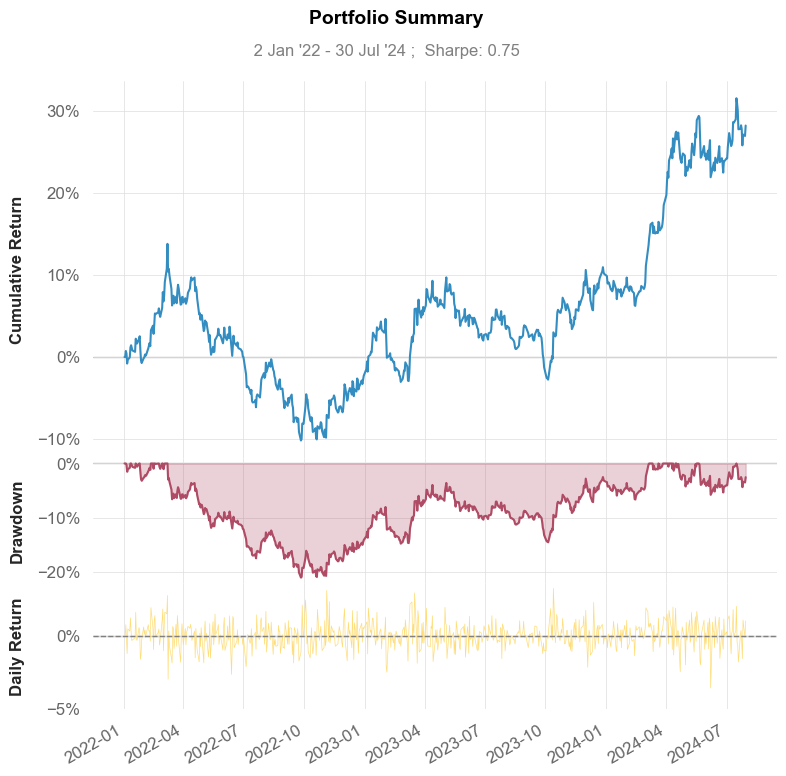

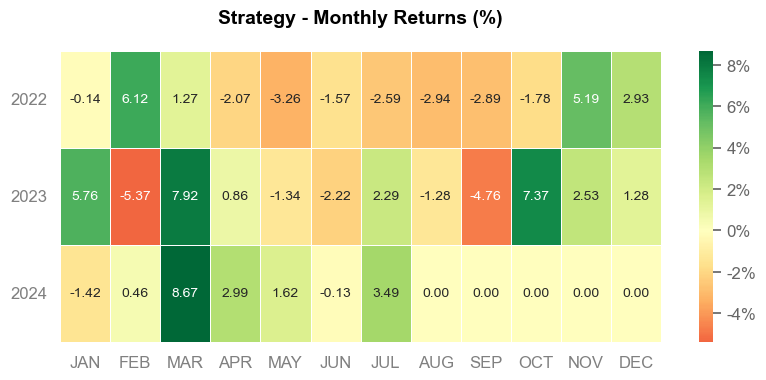

In [35]:
# Performance analysis
import quantstats as qs
# Generate a basic performance report for the equity curve
qs.reports.basic(equity_curve)

# End :)